In [1]:
using BenchmarkTools
using StellarChem
using StellarConstants
using StellarEOS
using StellarOpacity
using StellarEvolution

In [2]:
function equationHSE(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                            eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                            κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    if k==sm.nz
        lnP₀ = var00[sm.vari[:lnP]]
        r₀ = exp(var00[sm.vari[:lnr]])
        g₀ = CGRAV*sm.mstar/r₀^2
        return lnP₀ -log(2g₀/(3κ00)) # Eddington gray, ignoring radiation pressure term
    end
    lnP₊ = varp1[sm.vari[:lnP]]
    lnP₀ = var00[sm.vari[:lnP]]
    lnPface = (sm.dm[k]*lnP₀ + sm.dm[k+1]*lnP₊)/(sm.dm[k]+sm.dm[k+1])
    r₀ = exp(var00[sm.vari[:lnr]])
    dm = (sm.m[k+1]-sm.m[k])
    
    return (exp(lnPface)*(lnP₊ - lnP₀)/dm + CGRAV*sm.m[k]/(4π*r₀^4))/(CGRAV*sm.m[k]/(4π*r₀^4))
end

function equationT(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                          eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                          κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    if k==sm.nz
        lnT₀ = var00[sm.vari[:lnT]]
        L₀ = var00[sm.vari[:lum]]*LSUN
        r₀ = exp(var00[sm.vari[:lnr]])
        return lnT₀ - log(L₀/(BOLTZ_SIGMA*4π*r₀^2))/4 # Eddington gray, ignoring radiation pressure term
    end
    κface = exp((sm.dm[k]*log(κ00) + sm.dm[k+1]*log(κp1))/(sm.dm[k]+sm.dm[k+1]))
    L₀ = var00[sm.vari[:lum]]*LSUN
    r₀ = exp(var00[sm.vari[:lnr]])
    Pface = exp((sm.dm[k]*var00[sm.vari[:lnP]] + sm.dm[k+1]*varp1[sm.vari[:lnP]])/(sm.dm[k]+sm.dm[k+1]))
    lnT₊ = varp1[sm.vari[:lnT]]
    lnT₀ = var00[sm.vari[:lnT]]
    Tface = exp((sm.dm[k]*lnT₀ + sm.dm[k+1]*lnT₊)/(sm.dm[k]+sm.dm[k+1]))

    ∇ᵣ = 3κface*L₀*Pface/(16π*CRAD*CLIGHT*CGRAV*sm.m[k]*Tface^4)

    return (Tface*(lnT₊ - lnT₀)/sm.dm[k] + CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)*∇ᵣ)/(CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)) # only radiative transport
end

function equationLuminosity(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                          eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                          κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    L₋::TT = 0 # central luminosity is zero at first cell
    if k>1
        L₋ = varm1[sm.vari[:lum]]*LSUN # change it if not at first cell
    end
    L₀ = var00[sm.vari[:lum]]*LSUN
    ρ₀ = eos00[1]
    cₚ = eos00[5]
    δ = eos00[6]
    dTdt = (exp(var00[sm.vari[:lnT]]) - exp(sm.ssi.lnT_old[k]))/sm.ssi.dt
    dPdt = (exp(var00[sm.vari[:lnP]]) - exp(sm.ssi.lnP_old[k]))/sm.ssi.dt
    return ((L₀-L₋)/sm.dm[k]+cₚ*dTdt -(δ/ρ₀)*dPdt) # no nuclear reactions or neutrinos
end

function equationContinuity(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                   eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                   κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    ρ₀ = eos00[1]
    r₀ = exp(var00[sm.vari[:lnr]])
    r₋::TT = 0 # central radius is zero at first cell
    if k>1
        r₋ = exp(varm1[sm.vari[:lnr]]) # change it if not at first cell
    end
    
    dm = sm.m[k] # this is only valid for k=1
    if k>1
        dm = dm-sm.m[k-1]
    end

    #expected_r₀ = r₋ + dm/(4π*r₋^2*ρ)
    expected_dr³_dm = 3/(4π*ρ₀)
    actual_dr³_dm = (r₀^3-r₋^3)/dm
    
    return (expected_dr³_dm - actual_dr³_dm)*ρ₀
end

function equationH1(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return var00[sm.vari[:H1]] - 1.0
end

function equationHe4(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return var00[sm.vari[:He4]] - 1.0
end

equationHe4 (generic function with 1 method)

In [3]:
nvars = 5
nspecies = 1
varnames = [:lnP,:lnT,:lnr,:lum,:H1]
structure_equations=[equationHSE, equationT,
                        equationContinuity, equationLuminosity,
                        equationH1, equationHe4]
nz = 1000
eos = StellarEOS.IdealEOS(true)
opacity = StellarOpacity.SimpleElectronScatteringOpacity()
sm = StellarModel(varnames, structure_equations, nvars, nspecies, nz, eos, opacity);

In [4]:
sm.mstar = MSUN
function r_const_ρ(m,ρ)
    return @. (3m/(4π*ρ))^(1/3)
end
function P_const_ρ(m,ρ,M)
    Pc = 3*CGRAV/(8π)*(4π*ρ/3)^(4/3)*M^(2/3)
    return @. -3*CGRAV/(8π)*(4π*ρ/3)^(4/3)*m^(2/3) + Pc
end
function T_const_ρ(m,ρ,M, XH1, XHe4, isotope_data)
    P = P_const_ρ(m,ρ,M)
    μ = StellarEOS.get_μ_IdealEOS(isotope_data,[XH1,XHe4], [:H1,:He4])
    return @. P*μ/(CGAS*ρ)
end

T_const_ρ (generic function with 1 method)

In [5]:
# create a profile for composition that better resolves edges
function get_logdq(k, nz, logdq_low, logdq_high, numregion)
    if k<numregion
        return logdq_low+(k-1)*(logdq_high - logdq_low)/(numregion-1)
    elseif k<nz-numregion
        return logdq_high
    else
        k0 = nz-numregion
        k1 = nz
        return logdq_high+(logdq_low-logdq_high)*(k-k0)/(k1-k0)
    end
end
logdqs = get_logdq.(1:sm.nz,sm.nz,-3.0,0.0,100)
dqs = 10 .^ logdqs
dqs = dqs./sum(dqs)
dms = dqs.*MSUN
m_face = cumsum(dms)
m_cell = cumsum(dms)
#correct m_center
for i in 1:sm.nz
    if i==1
        m_cell[i] = 0
    elseif i!=sm.nz
        m_cell[i] = m_cell[i] - 0.5*dms[i]
    end
end

In [6]:
isotope_list = StellarChem.get_isotope_list()

#values at cell center
for i in 1:sm.nz
    ρ = 0.01
    XH = 1.0
    #XHe = 0.3
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnr]] = log(r_const_ρ(m_cell[i],ρ))
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]] = log(P_const_ρ(m_cell[i],ρ,MSUN))
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]] = log(T_const_ρ(m_cell[i],ρ,MSUN,1.0,0.0,isotope_list))
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:H1]] = XH
    #sm.ind_vars[(i-1)*sm.nvars+sm.vari[:He4]] = XHe
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lum]] = 1
end

#set dm and m at cell face
sm.dm = dms
sm.m = m_face
#evaluate radius
for i in 1:sm.nz
    ρ = 0.01
    XH = 1.0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnr]] = log(r_const_ρ(m_face[i],ρ))
end

#special cases, just copy values at edges
sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnP]] = sm.ind_vars[(2-1)*sm.nvars+sm.vari[:lnP]]
sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnT]] = sm.ind_vars[(2-1)*sm.nvars+sm.vari[:lnT]]
sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lum]] = 0
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnP]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lnP]]
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnT]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lnT]]
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lum]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lum]]

1.0

In [7]:
sm.ssi.dt = 365.25*24*3600
sm.ssi.lnT_old = zeros(sm.nz)
sm.ssi.lnP_old = zeros(sm.nz)
for i in 1:sm.nz
    sm.ssi.lnT_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]]
    sm.ssi.lnP_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]]
end

In [8]:
#@benchmark StellarEvolution.eval_jacobian_row!(sm,1)

In [9]:
#@benchmark StellarEvolution.eval_jacobian!(sm)

In [10]:
nsteps = 10000
Tcenter = zeros(nsteps)
Pcenter = zeros(nsteps)
Lsurf = zeros(nsteps)
Rsurf = zeros(nsteps)
Tsurf = zeros(nsteps)
times = zeros(nsteps)

time = 0
for k in 1:nsteps
    max_steps = 1500
    if k != 1
        max_steps = 100
    end

    sm.ssi.dt = 100*365.25*24*3600
    time = time + sm.ssi.dt
    sm.ssi.lnT_old = zeros(sm.nz)
    sm.ssi.lnP_old = zeros(sm.nz)
    for i in 1:sm.nz
        sm.ssi.lnT_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]]
        sm.ssi.lnP_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]]
    end

    for i in 1:max_steps
        StellarEvolution.eval_jacobian!(sm)
        StellarEvolution.eval_eqs!(sm)
        corr = sm.jac\(-sm.eqs)
        real_max_corr = maximum(corr)
        #scale correction
        if k==1
            corr = corr*min(1,0.1/maximum(corr))
        else
            corr = corr*min(1,0.5/maximum(corr))
        end
        if i%100==0
            @show i, maximum(corr), real_max_corr
        end
        # first try applying correction and see if it would give negative luminosity
        sm.ind_vars = sm.ind_vars+corr
        if real_max_corr<1e-10
            if k==1
                println("Found first model")
            end
            if k%200==0
                @show k, i, real_max_corr
            end
            break
        end
    end

    Tcenter[k] = exp(sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnT]])
    Pcenter[k] = exp(sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnP]])
    Lsurf[k] = sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lum]]*LSUN
    Rsurf[k] = exp(sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnr]])
    Tsurf[k] = exp(sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnT]])
    times[k] = time/(365.25*24*3600)
end

(i, maximum(corr), real_max_corr) = (100, 0.1, 4.496054386697812)


(i, maximum(corr), real_max_corr) = (200, 0.1, 0.8952461507727102)


Found first model


(k, i, real_max_corr) = (200, 3, 1.4162793112059357e-11)


(k, i, real_max_corr) = (400, 3, 2.872928741715858e-11)


(k, i, real_max_corr) = (600, 4, 8.686674665794325e-12)


(i, maximum(corr), real_max_corr) = (100, 0.5, 5.275141977809744)


(i, maximum(corr), real_max_corr) = (100, 0.5, 7.88520406201635)


(i, maximum(corr), real_max_corr) = (100, 0.5, 6.950449669963175)


(k, i, real_max_corr) = (800, 4, 1.9696099347049494e-14)


(k, i, real_max_corr) = (1000, 3, 2.0587880606928892e-13)


(k, i, real_max_corr) = (1200, 3, 3.858237752417596e-13)


(k, i, real_max_corr) = (1400, 3, 3.891907682882101e-13)


(k, i, real_max_corr) = (1600, 3, 4.399793168144372e-13)


(k, i, real_max_corr) = (1800, 3, 4.4945303545506e-13)


(k, i, real_max_corr) = (2000, 3, 4.3675965658155e-13)


(k, i, real_max_corr) = (2200, 3, 4.06867283145517e-13)


(k, i, real_max_corr) = (2400, 3, 3.698487534101293e-13)


(k, i, real_max_corr) = (2600, 3, 3.3984604017665967e-13)


(k, i, real_max_corr) = (2800, 3, 3.032629307280836e-13)


(k, i, real_max_corr) = (3000, 3, 2.7146900491840465e-13)


(k, i, real_max_corr) = (3200, 3, 2.4282644657917434e-13)


(k, i, real_max_corr) = (3400, 3, 2.2043966973103126e-13)


(k, i, real_max_corr) = (3600, 3, 1.9205674113901695e-13)


(k, i, real_max_corr) = (3800, 3, 1.774452771180321e-13)


(k, i, real_max_corr) = (4000, 3, 1.564975426764298e-13)


(k, i, real_max_corr) = (4200, 3, 1.403272379520775e-13)


(k, i, real_max_corr) = (4400, 3, 1.2567361810095703e-13)


(k, i, real_max_corr) = (4600, 3, 1.1055978860161074e-13)


(k, i, real_max_corr) = (4800, 3, 9.562511010707048e-14)


(k, i, real_max_corr) = (5000, 3, 9.662333480213104e-14)


(k, i, real_max_corr) = (5200, 3, 8.367409113907277e-14)


(k, i, real_max_corr) = (5400, 3, 7.75630204388e-14)


(k, i, real_max_corr) = (5600, 3, 6.974217927083711e-14)


(k, i, real_max_corr) = (5800, 3, 6.175346580382537e-14)


(k, i, real_max_corr) = (6000, 3, 6.034458812765673e-14)


(k, i, real_max_corr) = (6200, 3, 4.687767544792766e-14)


(k, i, real_max_corr) = (6400, 3, 4.807582145904891e-14)


(k, i, real_max_corr) = (6600, 3, 4.6316366002448204e-14)


(k, i, real_max_corr) = (6800, 3, 3.5996295730611185e-14)


(k, i, real_max_corr) = (7000, 3, 3.7429793746849314e-14)


(k, i, real_max_corr) = (7200, 3, 3.4392605241105153e-14)


(k, i, real_max_corr) = (7400, 3, 3.159958455658918e-14)


(k, i, real_max_corr) = (7600, 3, 3.449337274316653e-14)


(k, i, real_max_corr) = (7800, 3, 2.886827383663143e-14)


(k, i, real_max_corr) = (8000, 3, 3.1039404936387e-14)


(k, i, real_max_corr) = (8200, 3, 3.3622652983873394e-14)


(k, i, real_max_corr) = (8400, 3, 2.5938617828223166e-14)


(k, i, real_max_corr) = (8600, 3, 2.5073511371836596e-14)


(k, i, real_max_corr) = (8800, 3, 2.5309038113695658e-14)


(k, i, real_max_corr) = (9000, 3, 2.3580202383621632e-14)


(k, i, real_max_corr) = (9200, 3, 2.9846904792253464e-14)


(k, i, real_max_corr) = (9400, 3, 2.895363366790674e-14)


(k, i, real_max_corr) = (9600, 3, 3.225525497730838e-14)


(k, i, real_max_corr) = (9800, 3, 3.099387922127203e-14)


(k, i, real_max_corr) = (10000, 3, 3.0160437083494134e-14)


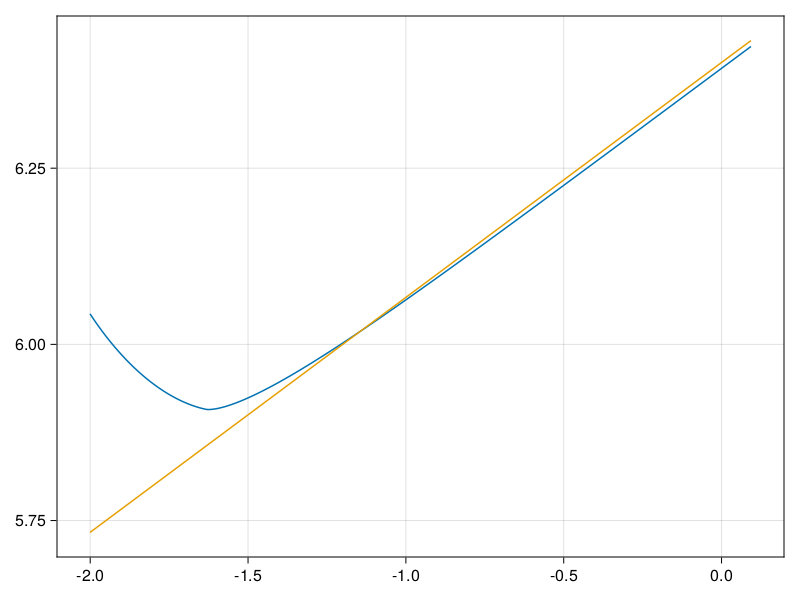

In [12]:
ρcenter = zeros(nsteps)
for i in 1:nsteps
    eos_result = get_EOS_resultsTP(sm.eos, sm.isotope_data,
        log(Tcenter[i]), log(Pcenter[i]), [1.0], [:H1])
    ρcenter[i] = eos_result[1]
end

using CairoMakie
f = Figure()
ax = Axis(f[1,1])
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, times, Pcenter)
lines!(ax, log10.(ρcenter), log10.(Tcenter))
lines!(ax, log10.(ρcenter), log10.(ρcenter)./3 .+ 6.4)
#lines!(ax, 1:10000, Lsurf)
#xlims!(ax,930,940)
f